In [1]:

import subprocess
import sys
sys.path.insert(0,'..')
from pathlib import Path
import os
import random

import torch
import torch.nn as nn
from torch.nn.functional import one_hot
from torch import Tensor
from typing import Union

import matplotlib.pylab as plt

import time
import numpy as np
import torch as th
import torch.nn as nn
from torch.utils import data
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, WeightedRandomSampler
import torch.optim.lr_scheduler as lr_scheduler

from focal_loss import FocalLoss
from utils import _axat, _atxa, _mvmt
import seaborn as sns


def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package],
                         stdout=subprocess.DEVNULL,
                         stderr=subprocess.DEVNULL
                         )
required_packages = [
    "geoopt",
    "pyriemann",
]
for package in required_packages:
    try:
        __import__(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"{package} is not installed. Installing...")
        install(package)

import geoopt
from pyriemann.utils.covariance import covariances, normalize


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.manifold import TSNE
import pandas as pd


use_cuda = th.cuda.is_available()
device = th.device("cuda:0" if use_cuda else "cpu")
print(device)

geoopt is already installed.
pyriemann is already installed.
cuda:0


## Defining Flags and Variables

In [2]:

# Flags and Parameters
root_dir = r"/kaggle/input/normalized-data/"
npz_file = "98_p_norm_data.npz"
folder_name = "mm_216"
os.makedirs(folder_name, exist_ok=True)
batch_size = 64  # batch size
n_classes = 11
random_seed = 42
test_size = 0.2
temp = False  # Whether the data is in temporal mode
val = True  # Whether to create a validation loader
combo = True  # Whether the data is in combo mode

model_name = "model_combo_linear_mm_216"
figure_name = "CM_combo_linear_mm_216"
tsne_fig_name ="Tsne_combo_linear_mm_216"
plot_figure_name = "training_validation_results_combo_linear_mm_216"
# for model

lr=1e-2
epochs=200
gamma_value=0.95
loss = "focal"
gamma_loss = 0.5
step_size=30
step_lr = False
linear_classif = True


## Model, Dataset, and Classifier definition

In [3]:
class BusemanSimilarityClassifier(nn.Module):
    def busemann_spd(self, logM):
        """
        Compute the Busemann similarity for Symmetric Positive Definite (SPD) matrices.
        
        :param logM: Logarithm of SPD matrices, shape (b, n, n)
        :return: Similarity scores, shape (b, n_proto)
        """
        return logM.reshape(logM.shape[0], -1) @ self.proto.reshape(self.proto.shape[0], -1).T
    def __init__(self,dim1,n_proto,n_classes,optim_proto=True):
        super().__init__()
        self.n_proto = n_proto
        self.n_classes = n_classes
        self.dim1 = dim1
        
        self.manifold = geoopt.Stiefel()

        # Random projection directions, shape (d-1, num_projections)
        theta = np.random.normal(size=(self.n_proto, self.dim1))
        theta = th.nn.functional.normalize(th.from_numpy(theta), p=2, dim=-1).type(th.float64).to(device)
        #self.D = theta[:,None] * th.eye(theta.shape[-1],dtype=th.float64, device=device)
        self.register_parameter("theta_proto", geoopt.ManifoldParameter(theta, geoopt.Sphere()))
        #self.theta_proto=theta

        ## Random orthogonal matrices
        Z = th.randn((self.n_proto, self.dim1, self.dim1), dtype=th.float64, device=device)
        self.Q = th.svd(Z)[0]
        self.manifold.assert_check_point_on_manifold(self.Q)
        self.register_parameter("Q_proto", geoopt.ManifoldParameter(self.Q, self.manifold))
        self.proto = _mvmt(self.Q_proto, self.theta_proto, self.Q_proto)
        # linear layer
        self.linear = nn.Linear(self.n_proto, self.n_classes).double()

    def forward(self, x):
        self.proto = _mvmt(self.Q_proto, self.theta_proto, self.Q_proto)
        y = self.linear(self.busemann_spd(x))#.view(sim_embedding.shape[0], -1))
        return y
    
    def embed(self, x):
        self.proto = _mvmt(self.Q_proto, self.theta_proto, self.Q_proto)
        return self.busemann_spd(x)

In [4]:
class LogEucRResNet(nn.Module):
    def __init__(self, inputdim=10, dim1=7, n_proto=12, classes=11, embed_only=False, linear_classif=False):
        super().__init__()
        self.inputdim = inputdim
        self.dim1 = dim1
        self.n_proto = n_proto
        self.classes = classes
        self.embed_only = embed_only
        self.linear_classif = linear_classif

        self.manifold_Stiefel = geoopt.Stiefel()
        self.manifold_SPD = geoopt.SymmetricPositiveDefinite("LEM")
        
        # init first bimap
        bm1 = th.randn((1, self.inputdim, self.dim1), dtype=th.float64)
        bm1 = th.svd(bm1)[0]
        self.register_parameter("bimap1", geoopt.ManifoldParameter(bm1, self.manifold_Stiefel))
        
        P = th.randn((1, self.dim1, self.dim1), dtype=th.float64)
        P = th.svd(P)[0]

        self.register_parameter("P1", geoopt.ManifoldParameter(P, self.manifold_Stiefel))

        self.classiflayer=BusemanSimilarityClassifier(self.dim1,self.n_proto, classes)
        self.fc_layer = nn.Linear(self.dim1 * self.dim1, self.classes).double()
        self.softmax =  nn.Softmax(dim=-1)

        self.spectrum_map = nn.Sequential(
            nn.Conv1d(1, 10, 5, padding="same").double(),
            nn.LeakyReLU(),
            nn.BatchNorm1d(10).double(),
            nn.Conv1d(10, 5, 3, padding="same").double(),
            nn.LeakyReLU(),
            nn.BatchNorm1d(5).double(),
            nn.Conv1d(5, 1, 3, padding="same").double(),
        )
        
    def forward(self, x):
        x = _atxa(self.bimap1, x)
        evecs, eigs, _ = th.svd(x)
        f_eigs = self.spectrum_map(eigs) # spectral map
        v1 = _mvmt(self.P1, f_eigs, self.P1)            
        v1 = self.manifold_SPD.proju(x, v1)
        eigs = th.clamp(eigs, 1e-4, 1e8)
        log_x = _mvmt(evecs, th.log(eigs), evecs)     
        x = log_x + v1
        if self.embed_only:
            return x.reshape(x.shape[0],-1)
        elif self.linear_classif:
            return self.softmax(self.fc_layer(x.reshape(x.shape[0],-1)))
        else:
            return self.softmax(self.classiflayer(x)) # Buseman Similarity Classifier when single modality is used
    def partial_forward(self, x):
        x = _atxa(self.bimap1, x)
        evecs, eigs, _ = th.svd(x)
        f_eigs = self.spectrum_map(eigs)
        v1 = _mvmt(self.P1, f_eigs, self.P1)
        v1 = self.manifold_SPD.proju(x, v1)
        eigs = th.clamp(eigs, 1e-8, 1e8)
        log_x = _mvmt(evecs, th.log(eigs), evecs)
        x = log_x + v1
        return self.classiflayer.embed(x)
            
class LogEucRResNet_Combo(nn.Module):
    def __init__(self, inputdim_temp=36, dim1_temp=24, inputdim_spec=10, dim1_spec=7, n_proto=12, classes=11, buseman_classif=True):
        super().__init__()
        self.classes = classes
        self.buseman_classif = buseman_classif
        self.model_temp = LogEucRResNet(inputdim_temp, dim1_temp, n_proto, embed_only=True)
        self.model_spectral = LogEucRResNet(inputdim_spec, dim1_spec, n_proto, embed_only=True)
        
        self.classiflayer = BusemanSimilarityClassifier(dim1_temp+1,n_proto,classes)
        self.fc_layer = nn.Linear(dim1_temp*dim1_temp+dim1_spec*dim1_spec,classes).double()        
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x1, x2):
        out_1 = self.model_temp(x1) # probabilities
        out_2 = self.model_spectral(x2) # probabilities
        x = th.concat((out_1, out_2), dim=1)
        #print(x.shape)
        if self.buseman_classif:
            return self.softmax(self.classiflayer(x))
        else:
            return self.softmax(self.fc_layer(x))
        
    def partial_forward(self, x1, x2):
        out_1 = self.model_temp.partial_forward(x1)
        out_2 = self.model_spectral.partial_forward(x2)
        x = th.concat((out_1, out_2), dim=1)
        return self.classiflayer.embed(x)

In [5]:
class TS_COV(Dataset):
    def __init__(self, root_dir, np_file, estimator='scm', combo=True, temp=False):
        self.root_dir = root_dir
        self.np_file = np_file
        self.estimator = estimator
        self.combo = combo
        self.temp = temp
        self.x, self.y, self.class_names = self.load_data()
        #self.cov = normalize(self.calculate_covariances(),'corr')
        self.x1 = self.calculate_covariances_36()
        self.x2 = self.calculate_covariances_10()
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x1, x2= self.x1[idx], self.x2[idx]
        y_sample = self.y[idx]
        class_name = self.class_names[y_sample]
        x1 = th.from_numpy(np.asarray([x1])).double()
        x2 = th.from_numpy(np.asarray([x2])).double()
        x1,x2 = x1.reshape(1, 36, 36), x2.reshape(1, 10, 10)
        y = th.from_numpy(np.array(y_sample)).long()
        if self.combo:
            return x1,x2, y
        elif self.temp:
            return x1, y
        else:
            return x2, y

    def load_data(self):
        file_path = os.path.join(self.root_dir, self.np_file)
        data = np.load(file_path, allow_pickle= True)
        x = data['series']
        y = data['labels']
        class_names = data['class_names']
        return x, y, class_names

    def calculate_covariances_10(self):
        x_transposed = np.transpose(self.x, (0, 2, 1))
        cov = covariances(x_transposed, estimator=self.estimator)
        return cov
    def calculate_covariances_36(self):
        cov = covariances(self.x, estimator=self.estimator)
        return cov

## Helper functions

In [6]:
def initialize_model(combo=True, linear_classif=True, temp=False, device=device):
    if combo:
        if linear_classif:
            model = LogEucRResNet_Combo(buseman_classif=False).to(device)
            print("Combo model with linear classifier")
        else:
            model = LogEucRResNet_Combo(buseman_classif=True).to(device)
            print("Combo model with Buseman classifier")
    elif temp:
        if linear_classif:
            inputdim = 36
            dim1 = 24
            model = LogEucRResNet(inputdim, dim1, linear_classif=True).to(device)
            print("Single modality - Temp model with linear classifier")
        else:
            inputdim = 36
            dim1 = 24
            model = LogEucRResNet(inputdim, dim1, linear_classif=False).to(device)
            print("Single modality - Temp model with Buseman classifier")
    else:
        if linear_classif:
            inputdim = 10
            dim1 = 7
            model = LogEucRResNet(inputdim, dim1, linear_classif=True).to(device)
            print("Single modality - Spectral model with linear classifier")
        else:
            inputdim = 10
            dim1 = 7
            model = LogEucRResNet(inputdim, dim1, linear_classif=False).to(device)
            print("Single modality - Spectral model with Buseman classifier")

    # Get number of trainable parameters
    model.eval()
    trainable_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Trainable total parameters: {trainable_total_params}')
    return model

# calculate the weights for the classes
def calculate_class_weights(labels):
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    weight = 1 - class_sample_count / len(labels)
    return th.from_numpy(weight).double()
# data loaders
def create_data_loaders(dataset, train_indices, val_indices, test_indices, batch_size, val=True):
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(test_indices), shuffle=False)
    
    if val:
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_indices))
        return train_loader, val_loader, test_loader
    else:
        return train_loader, test_loader
    
# plotting data distribution
def plot_class_distribution(train_loader, val_loader, test_loader, n_classes, combo=False):
    class_names = train_loader.dataset.class_names
    
    def count_labels(loader, n_classes):
        counts = np.zeros(n_classes)
        for batch in loader:
            if combo:
                _, _, labels = batch  # x1, x2, labels
            else:
                _, labels = batch  # x, labels
            for l in labels:
                counts[l] += 1
        return counts

    train_counts = count_labels(train_loader, n_classes)
    
    if val_loader is not None:
        val_counts = count_labels(val_loader, n_classes)
    else:
        val_counts = np.zeros(n_classes)
    
    test_counts = count_labels(test_loader, n_classes)

    # Bar plot
    plt.figure(figsize=(12, 6))
    plt.bar(np.arange(n_classes) - test_size, train_counts, 0.2, label='Train')
    if val_loader is not None:
        plt.bar(np.arange(n_classes), val_counts, 0.2, label='Validation')
    plt.bar(np.arange(n_classes) + 0.2, test_counts, 0.2, label='Test')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.yscale('log')
    if val_loader is not None:
        plt.title('Class Distribution in Train, Validation, and Test Sets')
    else:
        plt.title('Class Distribution in Train and Test Sets')
    plt.xticks(np.arange(n_classes), class_names, rotation=45)
    plt.legend(loc='best')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.bar(np.arange(n_classes), train_counts, alpha=0.5, label='Train')
    plt.bar(np.arange(n_classes), val_counts, alpha=0.5, label='Validation')
    plt.bar(np.arange(n_classes), test_counts, alpha=0.5, label='Test')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.yscale('log')
    if val_loader is not None:
        plt.title('Histogram of Class Distribution in Train, Validation, and Test Sets')
    else:
        plt.title('Histogram of Class Distribution in Train and Test Sets')
    plt.xticks(np.arange(n_classes), class_names, rotation=45)
    plt.legend(loc='best')
    plt.show()


In [7]:
# train the model
def train_model(model, train_loader, val_loader, loss_fn, optimizer, scheduler, epochs, combo=False):
    t1, t2, t3, t4, t5 = [], [], [], [], []
    device = th.device("cuda" if th.cuda.is_available() else "cpu")

    for epoch in range(epochs):
        start_time = time.time()  # Start time of the epoch
        model.train()

        # Training phase
        loss_train, acc_train = [], []
        for batch in train_loader:
            if combo:
                x1, x2, y = batch
                x1 = x1.to(device)
                x2 = x2.to(device)
                inputs = (x1, x2)
            else:
                x, y = batch
                x = x.to(device)
                inputs = (x,)
            y = y.to(device).long()
            optimizer.zero_grad()
            
            # Forward pass
            out = model(*inputs)
                
            l = loss_fn(out, y)
            
            acc, loss = (out.argmax(1) == y).cpu().numpy().sum() / out.shape[0], l.cpu().data.numpy()
            loss_train.append(loss)
            acc_train.append(acc)
            l.backward()
            optimizer.step()
        scheduler.step()

        acc_train = np.asarray(acc_train).mean()
        loss_train = np.asarray(loss_train).mean()
        t1.append(loss_train)
        t2.append(100 * acc_train)

        # Validation phase
        loss_val, acc_val_list = [], []
        y_true, y_pred = [], []
        model.eval()
        for batch in val_loader:
            if combo:
                x1, x2, y = batch
                x1 = x1.to(device)
                x2 = x2.to(device)
                inputs = (x1, x2)
            else:
                x, y = batch
                x = x.to(device)
                inputs = (x,)
            y = y.to(device).long()
            with th.no_grad():
                # Forward pass
                out = model(*inputs)
                    
                l = loss_fn(out, y)
                
            loss_val.append(l.cpu().data.numpy())
            predicted_labels = out.argmax(1)
            y_true.extend(list(y.cpu().numpy()))
            y_pred.extend(list(predicted_labels.cpu().numpy()))
            acc = (predicted_labels == y).cpu().numpy().sum() / out.shape[0]
            
            acc_val_list.append(acc)
        acc_val = np.asarray(acc_val_list).mean()
        loss_val = np.asarray(loss_val).mean()    
   
        t3.append(100 * acc_val)
        t4.append(loss_val)
        f1_test = f1_score(y_true, y_pred, average='macro')
        t5.append(100 * f1_test)
        print('Epoch {}/{} - Train loss: {:.4f} - Val loss: {:.4f} - Train acc: {:.2f}% - Val acc: {:.2f}% - Test F1-score: {:.2f}'.format(
            epoch + 1, epochs, loss_train, loss_val, 100 * acc_train, 100 * acc_val, 100 * f1_test))

        elapsed_time = time.time() - start_time
        print('Elapsed time: {:.2f} seconds'.format(elapsed_time))

    return t1, t2, t3, t4, t5

# plot the training results
def plot_training_results(t1, t2, t3, t4, t5, figure_name):
    plt.figure(figsize=(12, 8))
    plt.title("Training and Validation Loss and Accuracy")

    # Plot training and validation loss
    p1, = plt.plot(t1, label='Train loss', color='blue')
    p2, = plt.plot(t4, label='Validation loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    ax2 = plt.twinx()

    # Plot training and validation accuracy
    p3, = ax2.plot(t2, label='Train accuracy', color='orange')
    p4, = ax2.plot(t3, label='Validation accuracy', color='green')
    ax2.set_ylabel('Accuracy (%)')

    # Plot test F1-score
    p5, = ax2.plot(t5, label='F1-score', linestyle='dashed', color='purple')

    # Combine legends
    lines = [p1, p2, p3, p4, p5]
    labels = [line.get_label() for line in lines]
    #plt.legend(lines, labels, loc='upper right')
    plt.legend(lines, labels, loc='center left', bbox_to_anchor=(1.1, 0.5))

    # Save the figure with the provided name
    plot_filename = os.path.join(folder_name, f'{figure_name}.png')
    plt.savefig(plot_filename, bbox_inches='tight', pad_inches=0.2, dpi=500)
    print(f'Figure saved as {figure_name}.png')
    plt.show()

# evaluate the model
def evaluate_model(model, data_loader, loss_fn, model_name, figure_name, combo=False):
    loss_val, acc_val = [], []
    y_true, y_pred = [], []
    device = th.device("cuda" if th.cuda.is_available() else "cpu")

    model.eval()
    for batch in data_loader:
        if combo:
            x1, x2, y = batch
            x1 = x1.to(device)
            x2 = x2.to(device)
            inputs = (x1, x2)
        else:
            x, y = batch
            x = x.to(device)
            inputs = (x,)
        y = y.to(device).long()
        
        with th.no_grad():
            # Forward pass
            out = model(*inputs)
            l = loss_fn(out, y)
        
        predicted_labels = out.argmax(1)
        y_true.extend(list(y.cpu().numpy()))
        y_pred.extend(list(predicted_labels.cpu().numpy()))
        acc = (predicted_labels == y).cpu().numpy().sum() / out.shape[0]
        loss_val.append(l.cpu().data.numpy())
        acc_val.append(acc)

    acc_val = np.asarray(acc_val).mean()
    loss_val = np.asarray(loss_val).mean()

    print('Validation loss: {:.4f}'.format(loss_val))
    print('Validation accuracy: {:.2f}%'.format(100 * acc_val))

    # Save the model
    #save is a folder
    model_filename = os.path.join(folder_name, f'{model_name}.ckpt')
    th.save(model.state_dict(), model_filename)
    print(f'Model saved as {model_name}.ckpt')

    # Print classification report
    print(classification_report(y_true, y_pred, digits=2, target_names=data_loader.dataset.class_names))
    cmatrix = confusion_matrix(y_true, y_pred)
    Ncmatrix = cmatrix.astype('float') / cmatrix.sum(axis=1)[:, np.newaxis]

    group_counts = ['{0:0.0f}'.format(value) for value in cmatrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in Ncmatrix.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(n_classes, n_classes)

    # Plot and save the confusion matrix figure
    plt.figure(figsize=(10, 8))
    sns.heatmap(Ncmatrix, annot=labels, fmt='', cmap='Reds', xticklabels=data_loader.dataset.class_names, yticklabels=data_loader.dataset.class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n Acc={:.2f}%'.format(100 * acc_val))
    
    plot_name = os.path.join(folder_name, f'{figure_name}.png')
    plt.savefig(plot_name, bbox_inches='tight', pad_inches=0.2, dpi=500)
    plt.show()
    print(f'Figure saved as {figure_name}.png')

    return 100 * acc_val



In [8]:
# tsn-e plot

def gen_features(net, dataloader, combo=False, linear_classif = True):
    net.eval()
    targets_list = []
    outputs_list = []

    with th.no_grad():
        for idx, batch in enumerate(dataloader):
            if combo:
                x1, x2, targets = batch
                x1 = x1.to(device)
                x2 = x2.to(device)
                inputs = (x1, x2)
            else:
                x, targets = batch
                x = x.to(device)
                inputs = (x,)
            targets = targets.to(device)
            targets_np = targets.cpu().numpy()
            
            if linear_classif:
                outputs = net.forward(*inputs)
                outputs_np = outputs.data.cpu().numpy()
            else:
                if combo:
                    outputs = net.forward(*inputs)
                else:
                    outputs = net.partial_forward(*inputs)
                outputs_np = outputs.data.cpu().numpy()
            
            targets_list.append(targets_np[:, np.newaxis])
            outputs_list.append(outputs_np)

            if ((idx + 1) % 10 == 0) or (idx + 1 == len(dataloader)):
                print(idx + 1, '/', len(dataloader))

    targets = np.concatenate(targets_list, axis=0)
    outputs = np.concatenate(outputs_list, axis=0).astype(np.float64)

    return targets, outputs

def tsne_plot(fig_name, targets, outputs):
    print('generating t-SNE plot...')
    # tsne_output = bh_sne(outputs)
    tsne = TSNE(random_state=42, perplexity=50)
    tsne_output = tsne.fit_transform(outputs)

    df = pd.DataFrame(tsne_output, columns=['x', 'y'])
    df['targets'] = targets

    plt.rcParams['figure.figsize'] = 10, 10
    sns.scatterplot(
        x='x', y='y',
        hue='targets',
        palette=sns.color_palette("Paired", 11),
        data=df,
        marker='o',
        legend="full",
        alpha=0.5
    )

    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.legend(loc='best')
    plt.title('t-SNE plot of the embeddings: After training')


    plot_name = os.path.join(folder_name, f'{fig_name}.png')
    plt.savefig(plot_name, bbox_inches='tight', pad_inches=0.2, dpi=500)
    plt.show()
    print(f'Figure saved as {fig_name}.png')
    print('done!')


# Start

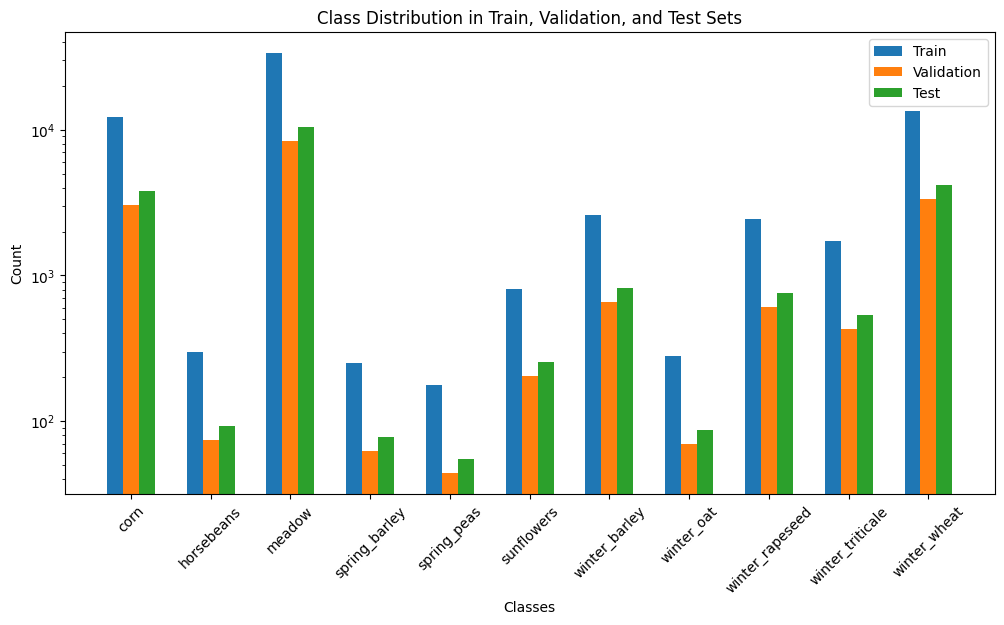

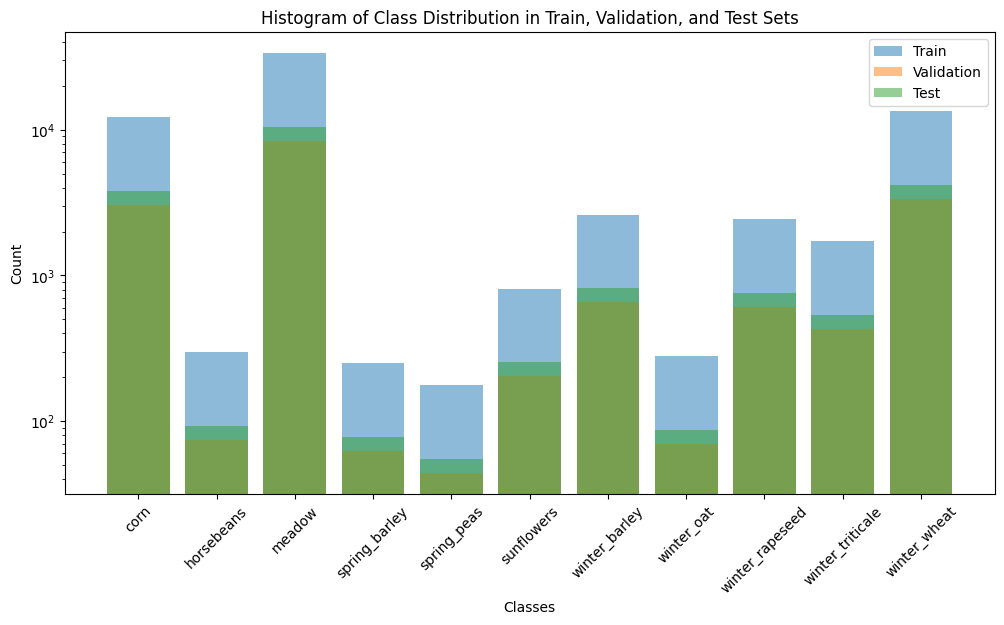

In [9]:
%matplotlib inline
# Initialize dataset
dataset = TS_COV(root_dir=root_dir, np_file=npz_file, estimator='scm', combo=combo, temp=temp)

# Split data into train, validation, and test sets
if val is not None:
    train_indices, test_indices = train_test_split(list(range(len(dataset))),
                                                    test_size=test_size, stratify=dataset.y, random_state=random_seed)
    train_indices, val_indices = train_test_split(train_indices,
                                                   test_size=test_size, stratify=dataset.y[train_indices], random_state=random_seed)
else:
    train_indices, test_indices = train_test_split(list(range(len(dataset))),
                                                   test_size=test_size, stratify=dataset.y, random_state=random_seed)
    val_indices = None

# Calculate class weights
weights = calculate_class_weights(dataset.y)
weights = weights.to(device)

# Create data loaders
if val:
    train_loader, val_loader, test_loader = create_data_loaders(dataset, train_indices, val_indices, test_indices, batch_size, val=val)
else:
    train_loader, test_loader = create_data_loaders(dataset, train_indices, val_indices, test_indices, batch_size, val=val)
    val_loader = None

# Plot class distribution
plot_class_distribution(train_loader, val_loader, test_loader, n_classes=n_classes, combo=combo)

In [10]:
# access one matri
if combo:
    for x1,x2, y in train_loader:
        print(x1.shape)
        print(x2.shape)
        print(y.shape)
        break
else:
    for x, y in train_loader:
        print(x.shape)
        print(y.shape)
        break
    

torch.Size([64, 1, 36, 36])
torch.Size([64, 1, 10, 10])
torch.Size([64])


In [11]:
# initialize the model
model = initialize_model(combo, linear_classif, temp, device)
# model.load_state_dict(th.load('model_temp_linear_mm_209.ckpt'))
model.eval()

Combo model with linear classifier
Trainable total parameters: 31965


/opt/conda/lib/python3.10/site-packages/geoopt/manifolds/symmetric_positive_definite.py:52: UserWarning: SPDMetric.LEM is not fully implemented and results may be not as you expect
  warnings.warn(


LogEucRResNet_Combo(
  (model_temp): LogEucRResNet(
    (manifold_Stiefel): Stiefel(canonical) manifold
    (manifold_SPD): SymmetricPositiveDefinite(default_metric=SPDMetric.LEM) manifold
    (classiflayer): BusemanSimilarityClassifier(
      (manifold): Stiefel(canonical) manifold
      (linear): Linear(in_features=12, out_features=11, bias=True)
    )
    (fc_layer): Linear(in_features=576, out_features=11, bias=True)
    (softmax): Softmax(dim=-1)
    (spectrum_map): Sequential(
      (0): Conv1d(1, 10, kernel_size=(5,), stride=(1,), padding=same)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv1d(10, 5, kernel_size=(3,), stride=(1,), padding=same)
      (4): LeakyReLU(negative_slope=0.01)
      (5): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv1d(5, 1, kernel_size=(3,), stride=(1,), padding=same)
    )
  )
  (model_spectral): LogEucRR

In [12]:
#setup loss and optimizer

if loss == "focal":
    loss_fn = FocalLoss(gamma=gamma_loss,weights=weights)
else:
    loss_fn = nn.CrossEntropyLoss(weights=weights)
#opti = MixOptimizer(model.parameters(),lr=lr)
opti = geoopt.optim.RiemannianAdam(model.parameters(), lr=lr)
if step_lr:
    scheduler = lr_scheduler.StepLR(opti, step_size, gamma_value)
else:
    scheduler = lr_scheduler.ExponentialLR(opti, gamma=gamma_value)


Epoch 1/200 - Train loss: 0.3209 - Val loss: 0.2326 - Train acc: 90.96% - Val acc: 94.04% - Test F1-score: 70.13
Elapsed time: 29.79 seconds
Epoch 2/200 - Train loss: 0.2015 - Val loss: 0.1955 - Train acc: 94.24% - Val acc: 94.53% - Test F1-score: 75.35
Elapsed time: 27.67 seconds
Epoch 3/200 - Train loss: 0.1770 - Val loss: 0.2002 - Train acc: 94.96% - Val acc: 94.87% - Test F1-score: 73.98
Elapsed time: 27.33 seconds
Epoch 4/200 - Train loss: 0.1675 - Val loss: 0.1880 - Train acc: 95.22% - Val acc: 95.44% - Test F1-score: 74.28
Elapsed time: 27.11 seconds
Epoch 5/200 - Train loss: 0.1632 - Val loss: 0.1894 - Train acc: 95.32% - Val acc: 95.31% - Test F1-score: 74.88
Elapsed time: 27.39 seconds
Epoch 6/200 - Train loss: 0.1543 - Val loss: 0.1720 - Train acc: 95.68% - Val acc: 95.75% - Test F1-score: 78.09
Elapsed time: 27.50 seconds
Epoch 7/200 - Train loss: 0.1486 - Val loss: 0.2091 - Train acc: 95.79% - Val acc: 93.47% - Test F1-score: 76.14
Elapsed time: 27.48 seconds
Epoch 8/200 -

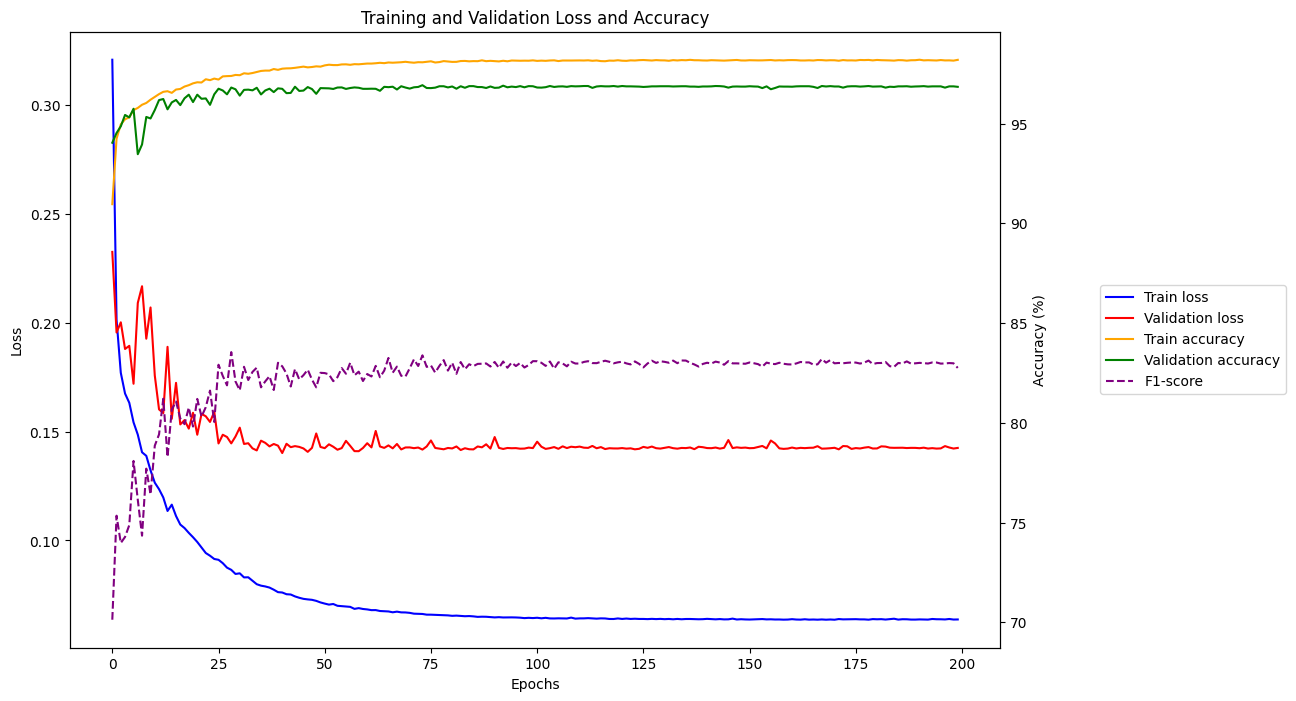

In [13]:
%matplotlib inline

if val:
    t1, t2, t3, t4, t5 = train_model(model, train_loader, val_loader, loss_fn, opti, scheduler, epochs, combo=combo)
else:
    t1, t2, t3, t4, t5 = train_model(model, train_loader, test_loader, loss_fn, opti, scheduler, epochs, combo=combo)

plot_training_results(t1, t2, t3, t4, t5, plot_figure_name)

Validation loss: 0.1490
Validation accuracy: 96.73%
Model saved as model_combo_linear_mm_216.ckpt
                  precision    recall  f1-score   support

            corn       0.98      0.98      0.98      3818
      horsebeans       0.76      0.79      0.78        92
          meadow       0.99      0.99      0.99     10508
   spring_barley       0.64      0.58      0.61        78
     spring_peas       0.78      0.73      0.75        55
      sunflowers       0.90      0.89      0.89       254
   winter_barley       0.94      0.94      0.94       817
      winter_oat       0.49      0.36      0.41        87
 winter_rapeseed       0.98      0.96      0.97       762
winter_triticale       0.78      0.69      0.73       537
    winter_wheat       0.95      0.97      0.96      4198

        accuracy                           0.97     21206
       macro avg       0.84      0.81      0.82     21206
    weighted avg       0.97      0.97      0.97     21206



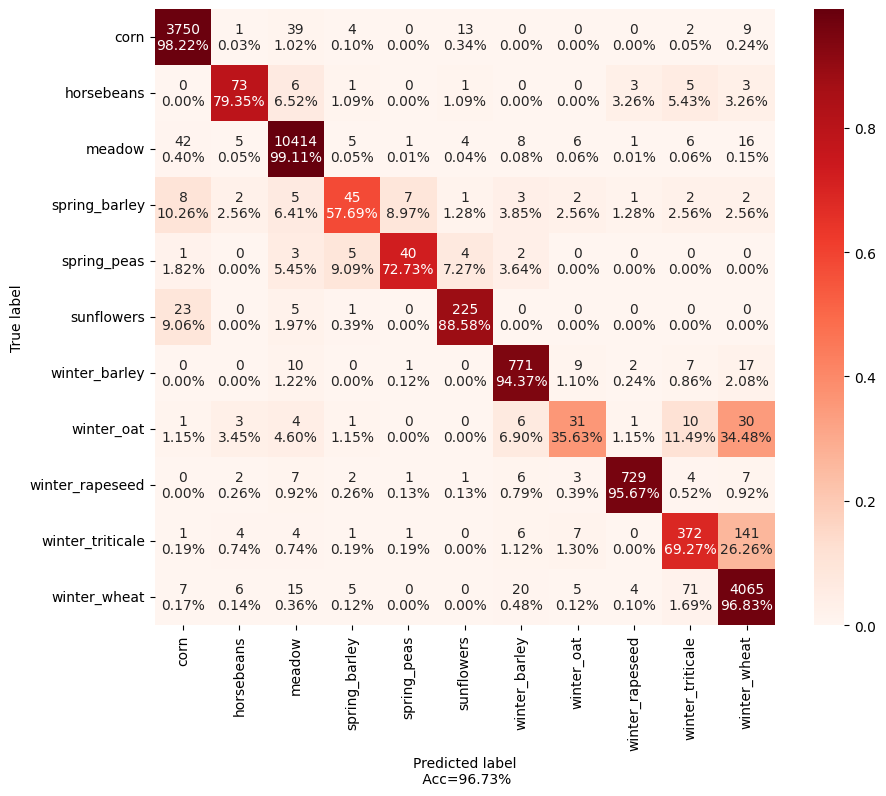

Figure saved as CM_combo_linear_mm_216.png


96.72995961117195

In [14]:
%matplotlib inline

evaluate_model(model, test_loader, loss_fn, model_name, figure_name, combo=combo)

10 / 332
20 / 332
30 / 332
40 / 332
50 / 332
60 / 332
70 / 332
80 / 332
90 / 332
100 / 332
110 / 332
120 / 332
130 / 332
140 / 332
150 / 332
160 / 332
170 / 332
180 / 332
190 / 332
200 / 332
210 / 332
220 / 332
230 / 332
240 / 332
250 / 332
260 / 332
270 / 332
280 / 332
290 / 332
300 / 332
310 / 332
320 / 332
330 / 332
332 / 332
generating t-SNE plot...


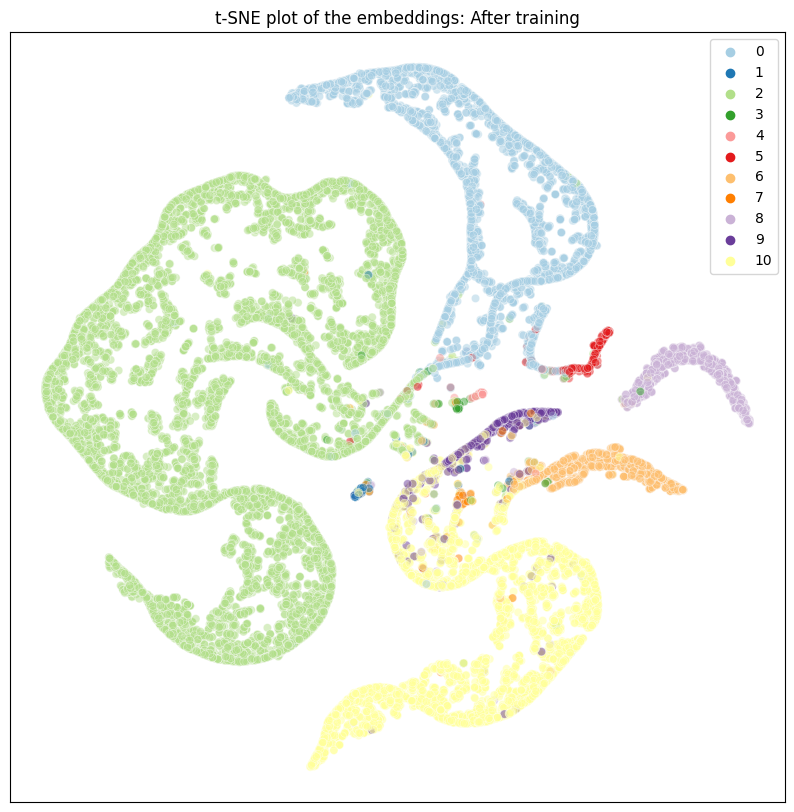

Figure saved as Tsne_combo_linear_mm_216.png
done!


In [15]:
%matplotlib inline

targets, outputs = gen_features(model,test_loader, combo =combo, linear_classif= linear_classif)
tsne_plot(tsne_fig_name,targets, outputs)
